In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import acos, sqrt, pi, cos

def cvtGrayscale(img):
    if len(img.shape) < 3:
        return img
    b, l, c = img.shape
    gray = np.zeros((b,l), dtype = "int64")
    for i in range(b):
        for j in range(l):
            gray[i][j] = (0.299*img[i][j][0] + 0.587*img[i][j][1] + 0.114*img[i][j][2])
    return gray

## Q3) Display the segmented image for coins.jpg using below mentioned methods and count the number of coins in each method:

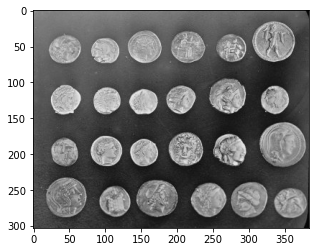

In [2]:
img_coins = cv2.imread('../images/coins.png')
plt.imshow(img_coins)

### 1) a) Thresholding.

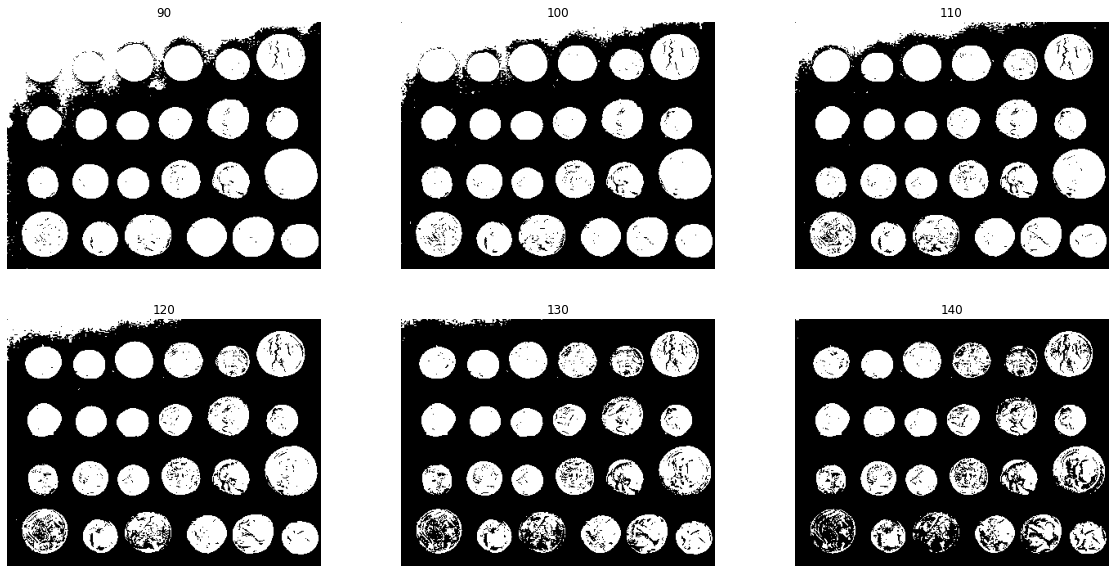

In [3]:
def threshold(img, val):
    img = cvtGrayscale(img)
    b ,l = img.shape
    out = np.copy(img)
    for i in range(b):
        for j in range(l):
            if img[i][j] > val:
                out[i][j] = 255
            else:
                out[i][j] = 0
    return out
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title(90+i*10)
    plt.axis("off")
    plt.imshow(threshold(img_coins, 90 + i*10), cmap='gray')

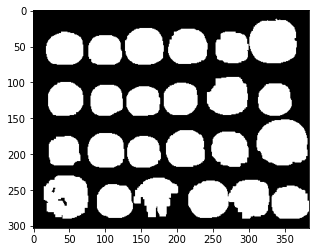

In [4]:
def dilation(img, SE, k):
    b, l = img.shape
    out = np.copy(img)
    window = np.copy(SE)
    p = k//2
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            if img[i][j] == 255 and k!= 1:
                
                tmp = img[i-p:i+p+1,j-p:j+p+1]
                

                for u in range(k):
                    for v in range(k):
                        if tmp[u][v] == 255 or SE[u][v] == 255:
                            window[u][v] = 255

                out[i-p:i+p+1,j-p:j+p+1] = window
    return out

def erode(img, SE, k):
    b, l = img.shape
    out = np.copy(img)
    window = np.copy(SE)
    p = k//2
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            if img[i][j] == 255 and k!= 1:
                
                tmp = img[i-p:i+p+1,j-p:j+p+1]
                window = np.copy(tmp)

                for u in range(k):
                    for v in range(k):
                        if tmp[u][v] == 255 and SE[u][v] == 255:
                            window[u][v] = 0
                            
                out[i-p:i+p+1,j-p:j+p+1] = window
    return out

se5 = np.array([[0,0,255,0,0],[0,255,255,255,0],[255,255,255,255,255],[0,255,255,255,0],[0,0,255,0,0]])
se3 = np.array([[0,255,0],[255,255,255],[0,255,0]])
er = erode(erode(threshold(img_coins,140), se5,5),se3,3)
fin = dilation(dilation(er,se5,5), se5,5)
plt.imshow(fin, cmap='gray')

Number of coins calculated:  24


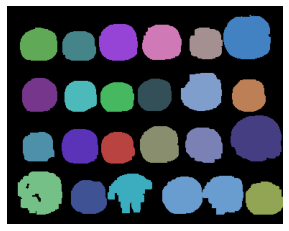

In [5]:
def twoPass(img):
    out = np.copy(img)
    if len(img.shape) > 2:
        img = cvtGrayscale(img)
    else:
        out = np.zeros((img.shape[0],img.shape[1],3))
    out = out.astype('int64')
    b, l = img.shape
    segments = np.zeros(img.shape, dtype='int64')
    unionfind = []
    s = 0
    unionfind.append(s)

    for i in range(b):
        for j in range(l):
            if img[i][j] == 255:
                if i>0 and j>0:
                    if segments[i-1][j] > 0 and segments[i][j-1] > 0:
                        top = unionfind[segments[i-1][j]]
                        left = unionfind[segments[i][j-1]]
                        unionfind[int(max(left,top))] = min(top, left)
                        segments[i][j] = min(top,left)
                    elif segments[i-1][j] > 0:
                        segments[i][j] = segments[i-1][j]
                    elif segments[i][j-1] > 0:
                        segments[i][j] = segments[i][j-1]
                    else:
                        s+=1
                        segments[i][j] = s
                        unionfind.append(s)
                elif i>0:
                    if segments[i-1][j]>0:
                        segments[i][j] = segments[i-1][j]
                elif j>0:
                    if segments[i][j-1]>0:
                        segments[i][j] = segments[i][j-1]
                else:
                    s+=1
                    segments[i][j] = s
                    unionfind.append(s)

    #print(s)
    for i in range(b):
        for j in range(l):
            if segments[i][j] > 0:
                curr = unionfind[segments[i][j]]
                while unionfind[int(curr)] != int(curr):
                    curr = unionfind[curr]
                unionfind[segments[i][j]] = curr
                segments[i][j] = curr
                
    #print(unionfind, s)
    colors = np.random.randint(50,220,size=(s,3),dtype='int64')
    for i in range(b):
        for j in range(l):
            if img[i][j] == 255:
                out[i][j] = colors[segments[i][j]-1]
    return out, len(np.unique(unionfind))
plt.axis('off')
out1, s1 = twoPass(fin)
print("Number of coins calculated: ", s1)
plt.imshow(out1)

### b) Otsu's Method

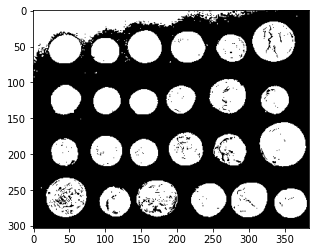

In [6]:
def otsu(img):
    if len(img.shape) > 2:
        img = cvtGrayscale(img)
    out = np.copy(img)
    b,l = img.shape
    freq = np.zeros(256)
    
    for i in range(b):
        for j in range(l):
            freq[img[i][j]] += 1
    total = b*l
    variance = 0
    final = 0
    means = 0
    wb = 0
    wf = 0
    sumb = 0
    
    for f in range(256):
        means += f*freq[f]
    
    for t in range(256):
        wb += freq[t]
        if wb == 0:
            continue
        wf = total - wb
        if wf == 0:
            break
        sumb += t*freq[t]
        mb = sumb/wb
        mf = (means - sumb)/wf
        temp = wb*wf*((mb-mf)**2)
        if temp>variance:
            variance = temp
            final = t
    
    for i in range(b):
        for j in range(l):
            if img[i][j]>final:
                out[i][j] = 255
            else:
                out[i][j] = 0
    return out

plt.imshow(otsu(img_coins), cmap='gray')

145


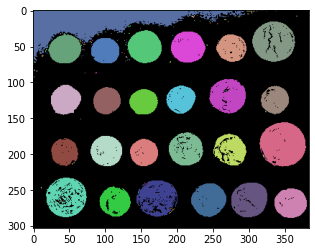

In [7]:
out1, s1 = twoPass(otsu(img_coins))
print(s1)
plt.imshow(out1,cmap='gray')

#### Result in in manually finding threshold gives better result as compared to otsu without any morphological help

### 2) Edge-based Segmentation

Number of coins counted =  30


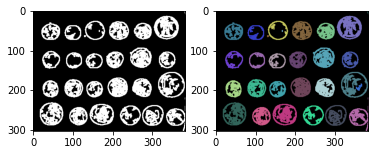

In [8]:
canny = cv2.Canny(img_coins, 100, 270)
canny = dilation(canny, se3,3)
plt.subplot(121)
plt.imshow(canny, cmap="gray")
plt.subplot(122)
out, s = twoPass(canny)
print("Number of coins counted = ",s)
plt.imshow(out,cmap='gray')

Number of coins counted=  39


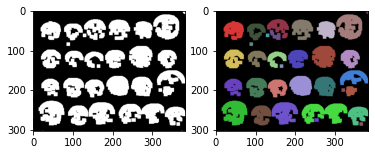

In [9]:
def sobel(img, k, d):
    kernel = np.zeros((k,k), dtype="int64")
    b, l = img.shape
    out = np.copy(img)
    if d == 0:
        kernel[0:k,0] = -1
        kernel[0:k,k-1] = 1
        kernel[k//2][0] = -2
        kernel[k//2][k-1] = 2
    if d == 1:
        kernel[0,0:k] = -1
        kernel[k-1,0:k] = 1
        kernel[0][k//2] = -2
        kernel[k-1][k//2] = 2
        
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.sum(tmp*kernel)
    return out
img_sobel = sobel(cvtGrayscale(img_coins), 3, 1)
img_sobel = threshold(img_sobel, 80)
img_sobel = dilation(dilation(erode(img_sobel,se3,3),se5,5),se5,5)
plt.subplot(121)
plt.imshow(img_sobel,cmap='gray')
plt.subplot(122)
out, s = twoPass(img_sobel)
print("Number of coins counted= ",s)
plt.imshow(out)

Number of coins ounted =  28


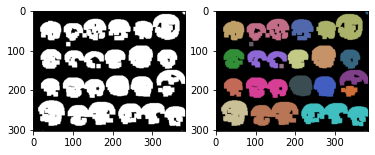

In [10]:
def laplacian(img, d):
    b, l = img.shape
    kernel = np.zeros((3,3))
    out = np.copy(img)
    if d == 0:
        kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    elif d == 1:
        kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])
    k = 3
    
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            p= k//2
            if k != 1:
                tmp = img[i-p:i+p+1,j-p:j+p+1]
            else:
                tmp = img[i][j]
            out[i][j] = np.sum(tmp*kernel)
    return out
img_lap = laplacian(cvtGrayscale(img_coins),1)
img_lap = dilation(threshold(img_sobel, 1),se3,3)
plt.subplot(121)
plt.imshow(img_lap, cmap= 'gray')
plt.subplot(122)
out ,s = twoPass(img_lap)
print("Number of coins ounted = ",s)
plt.imshow(out)

### OBSERVATION: Canny and Laplacian worked with a similar amount of success while Sobel didn't work as effectively.